In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# noinspection PyUnresolvedReferences
import tensorflow.keras as tk
# noinspection PyUnresolvedReferences
import tensorflow.keras.layers as l
# noinspection PyUnresolvedReferences
from tensorflow.keras.backend import clear_session
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import clone_model
# noinspection PyUnresolvedReferences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import sub_percentage_of, plot_accuracy_and_loss, plot_categorical_distribution_with_percentage

In [4]:
import os

working_locally = not os.path.exists('/kaggle/working') and not os.path.exists('/content')

In [5]:
if working_locally:
    train_path = "mitbih_train.csv"
    test_path = "mitbih_test.csv"
else:
    train_path = "/kaggle/input/heartbeat/mitbih_train.csv"
    test_path = "/kaggle/input/heartbeat/mitbih_test.csv"

train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

test_df.index = test_df.index + train_df.shape[0]

all_data = pd.concat([train_df, test_df])

all_data.rename(columns={187: 'class'}, inplace=True)

# Basic EDA

In [6]:
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_data['class'].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: class, dtype: int64

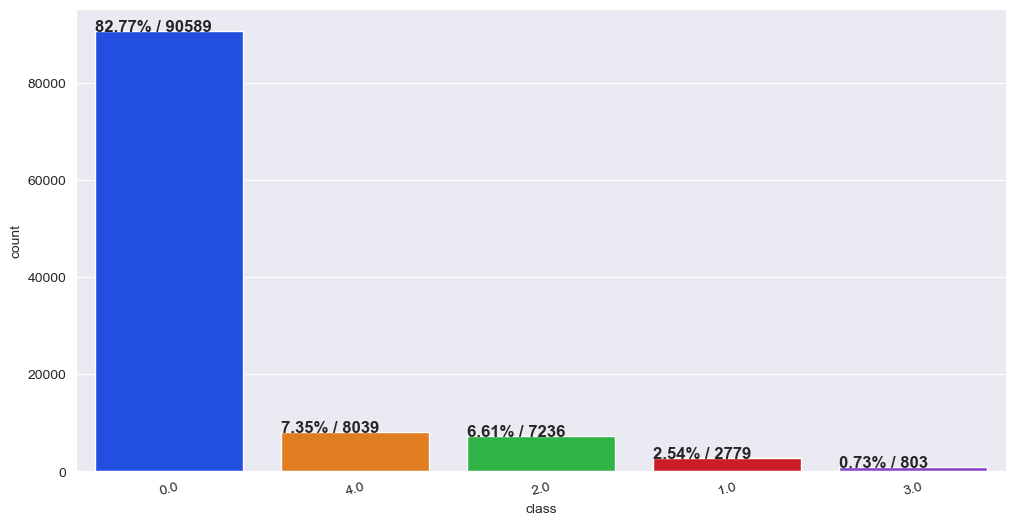

In [8]:
plot_categorical_distribution_with_percentage(all_data, "class")

In [9]:
train_final = all_data[all_data.index < train_df.shape[0]]
test_final = all_data[all_data.index >= train_df.shape[0]]

In [10]:
train_final.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
test_final.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
87554,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87555,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87556,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87557,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87558,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


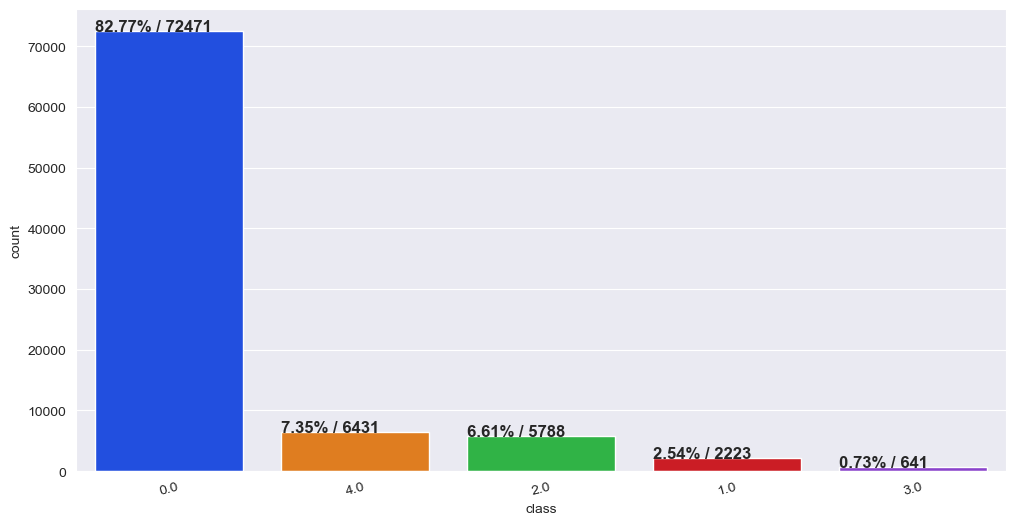

In [12]:
plot_categorical_distribution_with_percentage(train_final, "class")

In [ ]:
train_final.shape

In [ ]:
test_final.shape

# Models

In [ ]:
class_names =  ["Normal", "Artial Premature", "Premature ventricular contraction", "Fusion of ventricular and normal", "Fusion of paced and normal"]
number_of_features = 187

In [ ]:
def build_model():
    model = tk.Sequential([
        l.Conv1D(32, kernel_size=5, strides=2, activation="relu", input_shape=(number_of_features, 1)),
        l.BatchNormalization(),
        l.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.LSTM(128, return_sequences=True),
        l.LSTM(128),
        l.Dense(len(class_names), activation="softmax")
    ])
    optimizer = tk.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model


# Training stage

In [ ]:
EPOCHS = 5 if working_locally else 100

In [ ]:
from sklearn.model_selection import train_test_split



X = train_final.iloc[:, :-1].values
y = train_final.iloc[:, -1].values

y = to_categorical(y, num_classes=len(class_names))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_test = test_final.iloc[:, :-1].values
y_test = test_final.iloc[:, -1].values
y_test = to_categorical(y_test, num_classes=len(class_names))

In [ ]:
if working_locally:
    X_train, y_train = sub_percentage_of(X_train, y_train, 0.05)
    X_valid, y_valid = sub_percentage_of(X_valid, y_valid, 0.05)
    X_test, y_test = sub_percentage_of(X_test, y_test, 0.05)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
model = build_model()
early_stopping = tk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
test_labels = y_test.argmax(axis=1)
prediction_labels = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(test_labels, prediction_labels)
cm

In [ ]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot();

In [ ]:
model.save("model.h5")

In [ ]:
loaded_model = tk.models.load_model("model.h5")
loaded_model.evaluate(X_test, y_test)

In [ ]:
loaded_model.predict(X_test[:5])

### retraining using a balanced dataset

In [ ]:
from sklearn.utils import resample


def get_balanced_data():
    class0_df = train_df[train_df[187] == 0]
    class1_df = train_df[train_df[187] == 1]
    class2_df = train_df[train_df[187] == 2]
    class3_df = train_df[train_df[187] == 3]
    class4_df = train_df[train_df[187] == 4]

    class1_up_sampled = resample(class1_df, n_samples=20000, replace=True, random_state=1)
    class2_up_sampled = resample(class2_df, n_samples=20000, replace=True, random_state=1)
    class3_up_sampled = resample(class3_df, n_samples=20000, replace=True, random_state=1)
    class4_up_sampled = resample(class4_df, n_samples=20000, replace=True, random_state=1)

    class0_down_sampled = class0_df.sample(n=20000, random_state=0)

    return pd.concat([class0_down_sampled,
                      class1_up_sampled,
                      class2_up_sampled,
                      class3_up_sampled,
                      class4_up_sampled])


In [ ]:
balanced_train_df = get_balanced_data()

In [ ]:
X = balanced_train_df.iloc[:, :-1].values
y = balanced_train_df.iloc[:, -1].values

y = to_categorical(y, num_classes=len(class_names))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
if working_locally:
    X_train, y_train = sub_percentage_of(X_train, y_train, 0.05)
    X_valid, y_valid = sub_percentage_of(X_valid, y_valid, 0.05)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

In [ ]:
model = build_model()
early_stopping = tk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
prediction_labels = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(test_labels, prediction_labels)
cm

In [ ]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot();

In [ ]:
model.save('model_trained_on_balanced_data.h5')